# Example: Recent Analytics with DashDB (warm data)
## written in Python
Perform rather easy analytics and visualization with todays, this weeks, this months data. Not older!

### Add Data Source
go to the Data Source tab on the right hand menu, add source, from bluemix, and select my-dashdb. Next, select the line below and click on "Insert to code". The name of the credentials object should be **credentials_1**. Then click on the menu item "Cell" and click on "Run All".

In [2]:
from IPython.display import HTML
HTML('''<style>
div#notebook {
    background-color: #fafbfc;
    border-top: none;
}

div#notebook-container {
    background-color: #fafbfc;
}
</style>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
# property object with user credentials
props = {}
props['user'] = credentials_1['username']
props['password'] = credentials_1['password']

# fill in database name
tablename = "MYTABLE"
table = credentials_1['username'] + "." + tablename

# save dashDB data to DataFrame, show table schema
df = sqlContext.read.jdbc(credentials_1['jdbcurl'],table,properties=props)
df.printSchema()

root
 |-- TS: string (nullable = true)
 |-- TEMPERATURE: integer (nullable = true)
 |-- LIGHT: integer (nullable = true)
 |-- DOOROPEN: integer (nullable = true)
 |-- WINDOWOPEN: integer (nullable = true)
 |-- HUMIDITY: integer (nullable = true)
 |-- OXYGEN: integer (nullable = true)
 |-- WATERCONSUMPTION: integer (nullable = true)
 |-- ENERGYCONSUMPTION: integer (nullable = true)



In [5]:
import pandas as pd
%matplotlib inline

Timestamps and dates:

In [6]:
import datetime, time
# create current timestamp
ts = time.time()
# convert into UTC
curr_dt = datetime.datetime.utcfromtimestamp(ts)
curr_date = curr_dt.date()
# create start of week date
tsl = ts - 7*24*60*60
week_dt = datetime.datetime.utcfromtimestamp(tsl)
week_date= week_dt.date()
print "timezone:              ",time.tzname
print "current timestamp (tz):",ts
print "current datetime (utc):",curr_dt
print "current date     (utc):",curr_date
print "date a week ago  (utc):",week_date

timezone:               ('CST', 'CDT')
current timestamp (tz): 1466084912.72
current datetime (utc): 2016-06-16 13:48:32.718348
current date     (utc): 2016-06-16
date a week ago  (utc): 2016-06-09


In [7]:
print "Count:",df.count()

Count: 7540


In [8]:
# deduplicate
dedup = df.toPandas()
dedup = dedup.drop_duplicates(subset="TS")
df = sqlContext.createDataFrame(dedup)
print "Count after deduplication:",df.count()

Count after deduplication: 5983


In [9]:
# create columns date, year, month and time by slicing the timestamp
df_date = df.withColumn('DATE', df.TS[0:10])
df_date = df_date.withColumn('YEAR', df.TS[0:4])
df_date = df_date.withColumn('MONTH', df.TS[6:2])
df_date = df_date.withColumn('DAY', df.TS[9:2])
df_date = df_date.withColumn('TIME', df.TS[12:5])
panda = df_date.toPandas()

Table first 5 rows

In [10]:
panda.head()

,TS,TEMPERATURE,LIGHT,DOOROPEN,WINDOWOPEN,HUMIDITY,OXYGEN,WATERCONSUMPTION,ENERGYCONSUMPTION,DATE,YEAR,MONTH,DAY,TIME
0,2016-05-31T10:21:11.855Z,10,50,0,0,7,45,87,23,2016-05-31,2016,05,31,10:21
1,2016-05-31T10:22:11.868Z,19,514,0,0,51,20,10,10,2016-05-31,2016,05,31,10:22
2,2016-05-31T10:23:11.884Z,18,486,0,0,45,21,9,10,2016-05-31,2016,05,31,10:23
3,2016-05-31T10:24:11.893Z,20,485,0,0,45,21,9,10,2016-05-31,2016,05,31,10:24
4,2016-05-31T10:25:11.909Z,18,505,0,0,45,20,9,10,2016-05-31,2016,05,31,10:25


Table last 5 rows

In [11]:
panda.tail()

,TS,TEMPERATURE,LIGHT,DOOROPEN,WINDOWOPEN,HUMIDITY,OXYGEN,WATERCONSUMPTION,ENERGYCONSUMPTION,DATE,YEAR,MONTH,DAY,TIME
5978,2016-06-15T09:13:33.133Z,20,515,0,0,48,20,10,9,2016-06-15,2016,06,15,09:13
5979,2016-06-15T09:14:33.137Z,18,507,0,0,49,21,9,9,2016-06-15,2016,06,15,09:14
5980,2016-06-15T09:15:33.143Z,21,489,0,0,54,20,10,9,2016-06-15,2016,06,15,09:15
5981,2016-06-15T09:16:33.147Z,20,502,0,0,46,21,10,9,2016-06-15,2016,06,15,09:16
5982,2016-06-15T09:17:33.153Z,19,493,0,0,52,21,10,9,2016-06-15,2016,06,15,09:17


In [12]:
# create table with data from this day
#sameday = panda[panda['DATE']==curr_date]
sameday = df_date[df_date.DATE == curr_date]
sdcount = sameday.count()
print "Amount rows today: " , sdcount

Amount rows today:  28


In [13]:
#create table with data from this week
weekdays = df_date[df_date.DATE >= week_date]
wdcount = weekdays.count()
print "Amount rows week: " , wdcount

Amount rows week:  3633


# Questions

### Overview

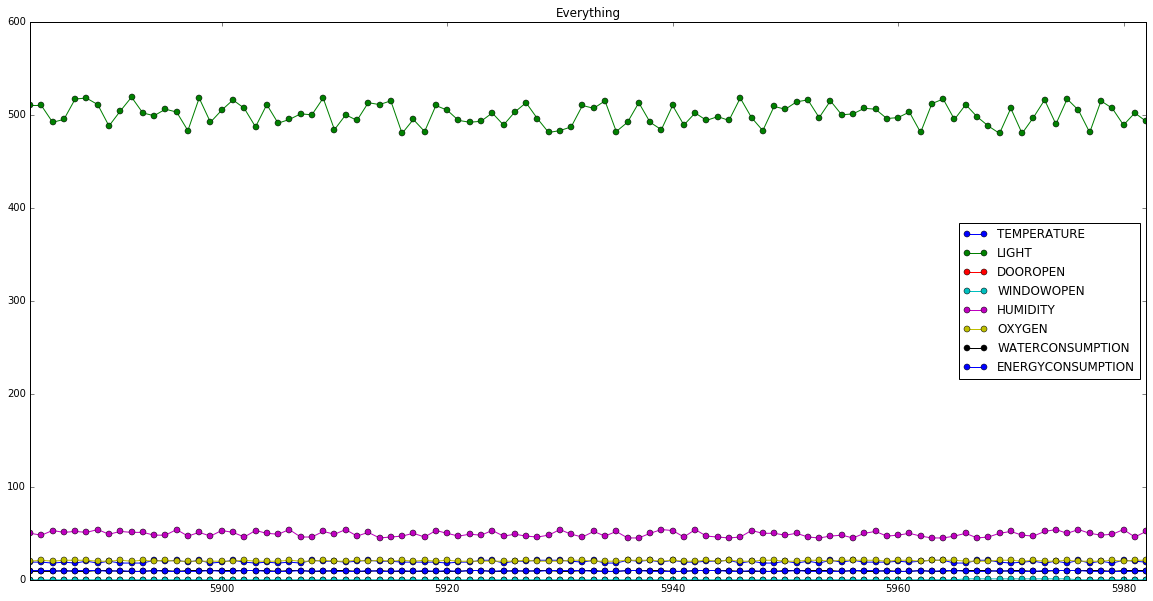

In [14]:
panda_overview = panda.tail(100)
panda_overview.plot(figsize=(20,10), marker='o', linestyle='-', title="Everything")

### 1) What is the total power and water consumption today in relation to the to the total consumption of this week and the average consumption?

Todays power consumption: 263
Weeks power consumption: 34499
Weeks average power consumption: 4928
Todays water consumption: 266
Weeks water consumption: 34729
Weeks average water consumption: 4961


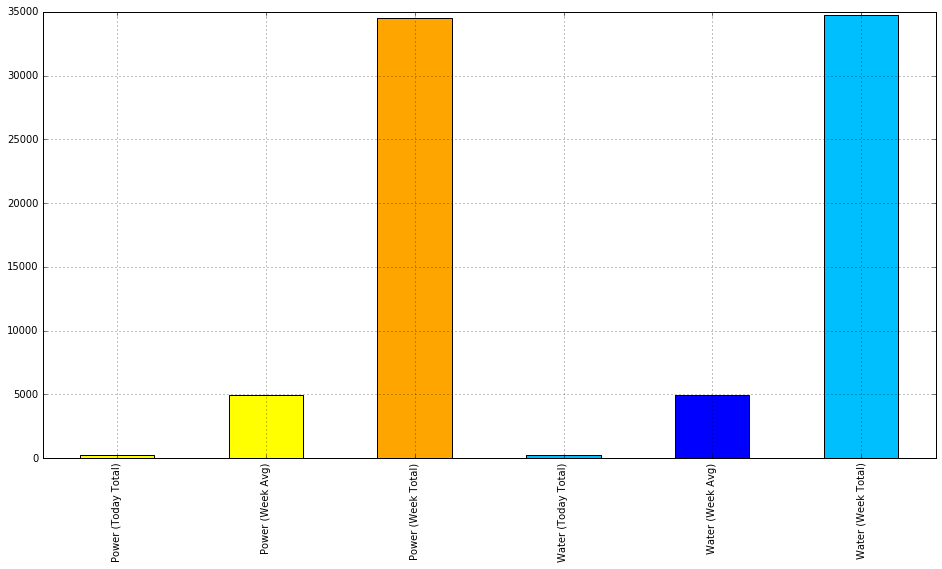

In [15]:
# required for colors
from itertools import cycle, islice

# calculate today total
power = sameday.groupBy().sum("ENERGYCONSUMPTION").first()['sum(ENERGYCONSUMPTION)']
water = sameday.groupBy().sum("WATERCONSUMPTION").first()['sum(WATERCONSUMPTION)']

# calculate week total and week average
powerw = weekdays.groupBy().sum("ENERGYCONSUMPTION").first()['sum(ENERGYCONSUMPTION)']
powerm = powerw / 7
waterw = weekdays.groupBy().sum("WATERCONSUMPTION").first()['sum(WATERCONSUMPTION)']
waterm = waterw / 7

# print
print "Todays power consumption:",power
print "Weeks power consumption:",powerw
print "Weeks average power consumption:",powerm
print "Todays water consumption:",water
print "Weeks water consumption:",waterw
print "Weeks average water consumption:",waterm

d = {'Power (Week Total)' : powerw, 'Power (Week Avg)' : powerm, 'Power (Today Total)' : power,'Water (Week Total)' : waterw, 'Water (Week Avg)' : waterm, 'Water (Today Total)' : water}
weeksconsumption = pd.Series(d)

# set colors
my_colors = list(islice(cycle(['yellow','yellow','orange','deepskyblue','blue','deepskyblue']), None, len(weeksconsumption)))
ax2 = weeksconsumption.plot(kind='bar', color=my_colors,figsize=(16,8))
ax2.yaxis.grid()
ax2.xaxis.grid()

### 2) What's the average of everything?

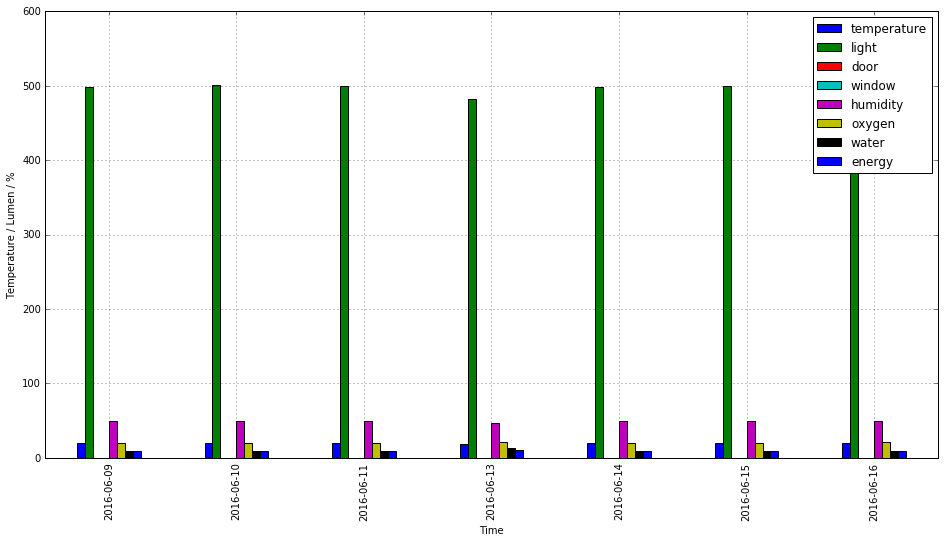

In [16]:
mean = weekdays.groupBy("DATE").avg().toPandas()

ax3 = mean.plot(kind="bar",figsize=(16,8),x='DATE')
ax3.set_ylabel("Temperature / Lumen / %")
ax3.set_xlabel("Time")
ax3.yaxis.grid()
ax3.xaxis.grid()
patches, labels = ax3.get_legend_handles_labels()
ax3.legend(patches, ['temperature','light','door','window','humidity','oxygen','water','energy'], loc='best')

### 3) How is the workplace condition?

In [17]:
workatmosphere = df.select(df.TEMPERATURE, df.HUMIDITY, df.OXYGEN, df.TS).toPandas()
recent_wa = workatmosphere.tail(20)

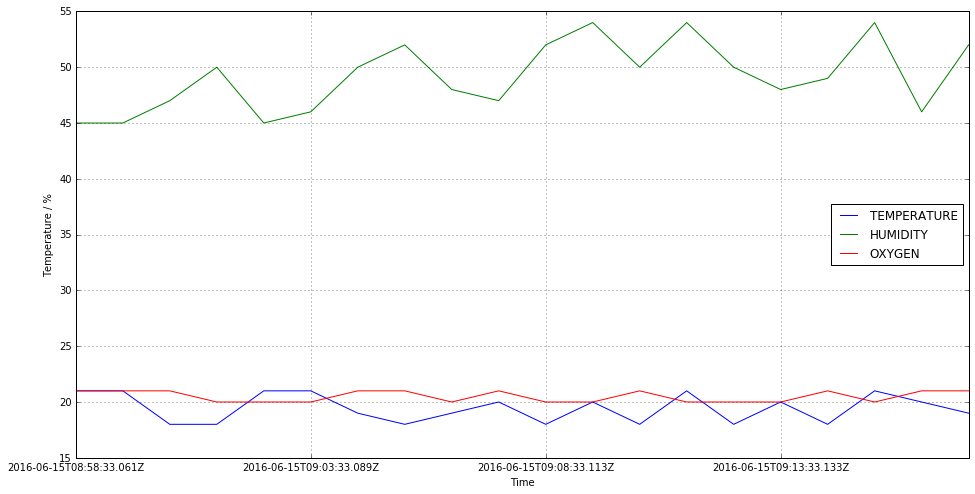

In [18]:
ax4 = recent_wa.plot(figsize=(16,8),x='TS')
ax4.set_ylabel("Temperature / %")
ax4.set_xlabel("Time")
ax4.yaxis.grid()
ax4.xaxis.grid()

In [19]:
worktemp = recent_wa.mean().TEMPERATURE
workhum = recent_wa.mean().HUMIDITY
workoxy = recent_wa.mean().OXYGEN
print "avg temperature: ",worktemp
print "avg humidity:    ",workhum
print "avg oxygen:      ",workoxy

avg temperature:  19.45
avg humidity:     49.2
avg oxygen:       20.5


In [20]:
if (18 < worktemp < 24) and (45 < workhum < 55) and (18 < workoxy < 22) :
    print "Workatmosphere is good"
else:
    print "Workatmosphere is bad"

Workatmosphere is good


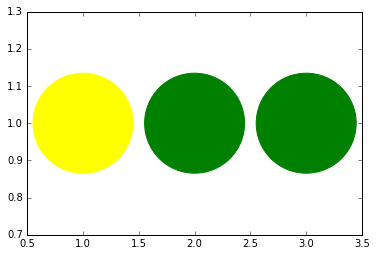

From left to right: Temperature, Humidity and Oxygen


In [21]:
if worktemp < 19:
    tc = "red"
elif worktemp < 20:
    tc = "yellow"
else:
    tc="green"
    
if workhum < 45 or workhum > 55:
    hc = "red"
elif workhum < 48 or workhum > 52:
    hc = "yellow"
else:
    hc= "green"

if workoxy < 18 or workoxy > 22:
    oc = "red"
elif workoxy < 19 or workoxy > 21:
    oc = "yellow"
else:
    oc= "green"
    
colors = [tc,hc,oc]

import numpy as np
import matplotlib.pyplot as plt
x = [1,2,3]
y = [1,1,1]
# Plot...
plt.scatter(x, y, color=colors, s=10000)
plt.show()
print "From left to right: Temperature, Humidity and Oxygen"

### 4) How many times were the windows and doors openend?

In [22]:
# using Spark Data Frame
dooropen = sameday[sameday.DOOROPEN==1]
dooropen = dooropen.count()
print "The door was", dooropen,"times opened today"

The door was 0 times opened today


In [23]:
# using Python Pandas
samedaypd = sameday.toPandas()
windowopen = samedaypd[samedaypd['WINDOWOPEN']==1]
windowopen = windowopen["WINDOWOPEN"].count()
print "The window was", windowopen,"times opened today"

The window was 0 times opened today


In [24]:
opened = samedaypd[['TS','DOOROPEN','WINDOWOPEN']]

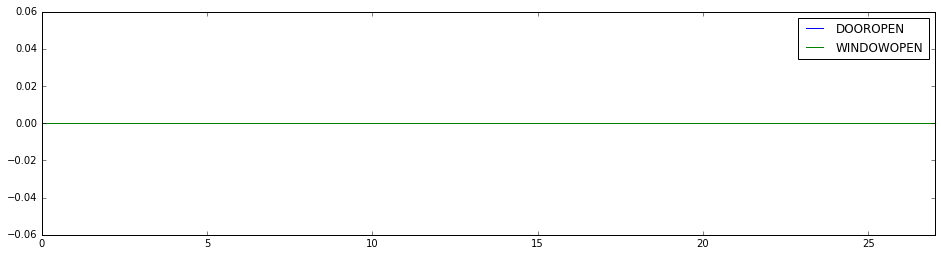

In [25]:
opened.plot(figsize=(16,4))

### 5) Were the windows and doors opened during night?

In [29]:
early = curr_date.isoformat() + "T06:00:00.000Z"
late = curr_date.isoformat() + "T23:00:00.000Z"
print "Alarm till  :",early
print "Alarm since :",late

Alarm till  : 2016-06-16T06:00:00.000Z
Alarm since : 2016-06-16T23:00:00.000Z


In [30]:
# time alarm early and late
tae = sameday.filter(early > sameday.TS).toPandas()
tal = sameday.filter(late < sameday.TS).toPandas()
alarms = tae.count()[0] + tal.count()[0]
print "Number of Alarms:",alarms

Number of Alarms: 0


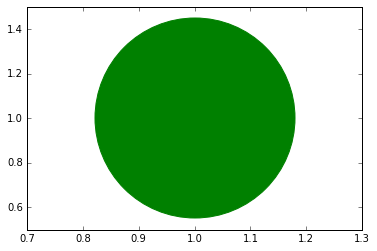

Windows and Door Alarm


In [31]:
if alarms > 30:
    clr = "red"
elif alarms > 5:
    clr = "yellow"
else:
    clr ="green"
    
import numpy as np
import matplotlib.pyplot as plt
x = [1]
y = [1]
# Plot...
plt.scatter(x, y, color=clr, s=40000)
plt.show()
print "Windows and Door Alarm"